In [1]:
import pandas as pd, numpy as np, os
from vivarium import Artifact
import db_queries
from get_draws.api import get_draws
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning) 

In [3]:
# Parameters cell for papermill
model_dir = "model27.0"

In [4]:
# Parameters
model_dir = "model27.1"


In [5]:
base_results_dir = f"/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/results/{model_dir}/"

In [6]:
# TODO: Use pathlib here
locations = []
results_dirs = []
for location in os.listdir(base_results_dir):
    locations.append(location)

    timestamps = sorted(os.listdir(base_results_dir + location))
    last_timestamp = timestamps[-1]
    if len(timestamps) > 1:
        print(f'Multiple timestamps: {timestamps}, using {last_timestamp}')

    results_dirs.append(location + '/' + last_timestamp + '/results/')

location_ids = db_queries.get_ids('location')
location_ids = location_ids.loc[location_ids.location_name.isin([x.title() for x in locations])]
#locations = list(location_ids.location_name.values)
#locations = [x.lower() for x in locations]
#location_ids = list(location_ids.location_id.values)
#location_ids, locations, results_dirs

results_dict = {
    location: results_dirs[locations.index(location)]
    for location
    in locations
}
results_dict

{'ethiopia': 'ethiopia/2026_01_22_09_55_33/results/',
 'pakistan': 'pakistan/2026_01_22_10_05_21/results/',
 'nigeria': 'nigeria/2026_01_22_10_01_54/results/'}

In [7]:
def read_results(data, baseline_only=True):
    df = pd.DataFrame()
    for result in results_dirs:
        temp = pd.read_parquet(base_results_dir + result + data + '.parquet').drop(columns=['measure','entity','entity_type','sub_entity'])
        temp['location'] = result.split('/')[0]
        if 'scenario' not in temp.columns:
            temp['scenario'] = 'baseline'
        # FIXME: Make this work, generally merge with read_results in other V&V notebooks
        #temp['model_version'] = result.split('/')[8]
        if baseline_only:
            temp = temp.loc[temp.scenario == 'baseline']
        if 'random_seed' in temp.columns:
            temp = temp.groupby([c for c in temp.columns if c != 'random_seed' and c != 'value']).sum().reset_index().drop(columns='random_seed')
        df = pd.concat([df, temp],ignore_index=True)
    return df

In [8]:
import yaml
def load_yaml_file(path):
    with open(path) as stream:
        return yaml.safe_load(stream)

In [9]:
artifact_paths = {
    location: load_yaml_file(base_results_dir + result_dir.replace('results/','') + 'model_specification.yaml')['configuration']['input_data']['artifact_path']
    for location, result_dir
    in results_dict.items()
}
artifact_paths

{'ethiopia': '/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model27.1/ethiopia.hdf',
 'pakistan': '/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model27.1/pakistan.hdf',
 'nigeria': '/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model27.1/nigeria.hdf'}

In [10]:
def load_location_data(location, key):
    art = Artifact(artifact_paths[location])
    art = art.load(key)
    art['location'] = location
    art = art.reset_index().set_index(['location'] + art.index.names)
    return art
    
def load_artifact_data(key):
    data = pd.concat([load_location_data(location, key) for location in locations])
    return data

In [11]:
deaths = read_results('neonatal_burden_observer_disorder_deaths', baseline_only=True)
# collapse preterm birth causes of death
deaths_preterm = deaths.loc[deaths.neonatal_burden_observer_cause_of_death.str.contains('preterm')]
deaths_preterm['neonatal_burden_observer_cause_of_death'] = 'neonatal_preterm_birth'
deaths_preterm = deaths_preterm.groupby([x for x in deaths_preterm.columns if x != 'value']).sum().reset_index()
deaths_all = deaths.groupby([x for x in deaths.columns if x not in ['value','neonatal_burden_observer_cause_of_death']])['value'].sum().reset_index()
deaths_all['neonatal_burden_observer_cause_of_death'] = 'all_causes'
deaths = pd.concat([deaths, deaths_preterm, deaths_all], ignore_index=True)
births =  read_results('births', baseline_only=True).rename(columns={'sex':'child_sex'})
#pregnancies = read_results('anc', baseline_only=True)

In [12]:
# check that there are no preterm birth deaths among non preterm babies if we have the stratification to do it

if 'preterm_birth' in deaths.columns:
    assert deaths.loc[(deaths.preterm_birth==False) 
                  & (deaths.neonatal_burden_observer_cause_of_death == 'neonatal_preterm_birth')].value.sum() == 0, "Preterm deaths among non-preterm babies"

In [13]:
# get "alive" counts at the beginning of each age group

groupby_cols = ['location','child_sex','input_draw','scenario']
def calculate_sim_mortality_ratio(groupby_cols):
    sim_mortality_ratio = pd.DataFrame()

    enn0 = births.loc[births.pregnancy_outcome=='live_birth'].groupby(groupby_cols)['value'].sum()
    enn_deaths = deaths.loc[(deaths.child_age_group == 'early_neonatal')
                            &(deaths.neonatal_burden_observer_cause_of_death=='all_causes')].groupby(groupby_cols)['value'].sum()
    lnn_0 = enn0 - enn_deaths

    for cause in list(deaths.neonatal_burden_observer_cause_of_death.unique()):
        enn_deaths = deaths.loc[(deaths.child_age_group == 'early_neonatal')
                                &(deaths.neonatal_burden_observer_cause_of_death == cause)].groupby(groupby_cols)['value'].sum()
        lnn_deaths = deaths.loc[(deaths.child_age_group == 'late_neonatal')
                                &(deaths.neonatal_burden_observer_cause_of_death == cause)].groupby(groupby_cols)['value'].sum()
        enn_mortality_ratio = (enn_deaths / enn0).reset_index()
        enn_mortality_ratio['child_age_group'] = 'early_neonatal'
        lnn_mortality_ratio = (lnn_deaths / lnn_0).reset_index()
        lnn_mortality_ratio['child_age_group'] = 'late_neonatal'

        # TODO: Give this a more descriptive name than `temp`, likely by accumulating these in a list
        # and doing pd.concat once
        temp = pd.concat([enn_mortality_ratio, lnn_mortality_ratio], ignore_index=True)
        temp['cause'] = cause
        sim_mortality_ratio = pd.concat([sim_mortality_ratio, temp], ignore_index=True)
    return sim_mortality_ratio

In [14]:
groupby_cols = ['location','child_sex','input_draw','scenario']
sim_mortality_ratio = calculate_sim_mortality_ratio(groupby_cols)
sim_mortality_ratio = sim_mortality_ratio.loc[sim_mortality_ratio.scenario == 'baseline']
sim_mortality_ratio.head()

,location,child_sex,input_draw,scenario,value,child_age_group,cause
0,ethiopia,Female,22,baseline,0.005068,early_neonatal,neonatal_encephalopathy_due_to_birth_asphyxia_...
1,ethiopia,Female,60,baseline,0.003772,early_neonatal,neonatal_encephalopathy_due_to_birth_asphyxia_...
2,ethiopia,Female,71,baseline,0.005471,early_neonatal,neonatal_encephalopathy_due_to_birth_asphyxia_...
3,ethiopia,Female,79,baseline,0.005581,early_neonatal,neonatal_encephalopathy_due_to_birth_asphyxia_...
4,ethiopia,Female,115,baseline,0.005198,early_neonatal,neonatal_encephalopathy_due_to_birth_asphyxia_...


In [15]:
sim_mortality_ratio.cause.unique()

array(['neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma',
       'neonatal_preterm_birth_with_rds',
       'neonatal_preterm_birth_without_rds',
       'neonatal_sepsis_and_other_neonatal_infections', 'other_causes',
       'neonatal_preterm_birth', 'all_causes'], dtype=object)

In [16]:
draws = list(sim_mortality_ratio.input_draw.unique())
draws

[22, 60, 71, 79, 115, 118, 146, 167, 197, 244]

In [17]:
documented_draws = [115, 60, 118, 197, 79, 244, 22, 167, 146, 71, 28, 156, 94, 170, 109, 26, 35, 114, 178, 127]
# obtained from: https://vivarium-research.readthedocs.io/en/latest/models/concept_models/vivarium_mncnh_portfolio/concept_model.html#id20
# on 11/3/2025

In [18]:
# check that all of the draws in simulation results are in the documented list
# TODO: do this with a set difference
for draw in draws:
    assert draw in documented_draws, f"Draw {draw} in simulation results but not documented draw list"

In [19]:
# TODO: name variable
c = db_queries.get_ids('cause')
# FIXME: What is this doing? Is there a less confusing way to get what we need here?
c = c.loc[(c.cause_name.isin([x.replace('_',' ').capitalize() for x in list(sim_mortality_ratio.cause.unique())]))
      | (c.cause_name.str.contains('reterm birth'))]
gbd_cause_ids = c.cause_id.unique()
c

,cause_id,cause_name,acause,cause_description
0,294,All causes,_all,None
87,381,Neonatal preterm birth,neonatal_preterm,None
88,382,Neonatal encephalopathy due to birth asphyxia ...,neonatal_enceph,None
89,383,Neonatal sepsis and other neonatal infections,neonatal_sepsis,None


In [20]:
# now load up matching GBD 2023 data
# TODO: Comment and make constants for these magic numbers (or get them from gbd_mapping or similar)

gbd_births = db_queries.get_population(location_id=[179,165,214],
                                release_id=16,
                                year_id=2023,
                                age_group_id=164,
                                sex_id=[1, 2])

In [21]:
gbd_deaths = get_draws(location_id=[179,165,214],
                                release_id=16,
                                year_id=2023,
                                source='codcorrect',
                                metric_id=1,
                                measure_id=1,
                                gbd_id=gbd_cause_ids,
                                age_group_id=[2,3], # enn and lnn
                                gbd_id_type='cause_id')

/mnt/share/homes/zmbc/mambaforge/envs/vivarium_gates_mncnh_artifact/lib/python3.11/site-packages/get_draws/api.py:194: UserWarning: No version_id was specified, so get_draws will automatically determine a best version ID to use from the given parameters. If you want to retrieve a specific version please pass a version_id directly.
  warnings.warn(


In [22]:
draw_cols = [f'draw_{c}' for c in draws]
draw_cols

['draw_22',
 'draw_60',
 'draw_71',
 'draw_79',
 'draw_115',
 'draw_118',
 'draw_146',
 'draw_167',
 'draw_197',
 'draw_244']

In [23]:
# FIXME: deduplicate
draw_cols = [f'draw_{c}' for c in draws]

gbd_enn_0 = gbd_births.set_index(['location_id','sex_id'])[['population']]
gbd_enn_deaths = gbd_deaths.loc[gbd_deaths.age_group_id==2].set_index(['location_id','sex_id','cause_id'])[draw_cols].reset_index()
gbd_enn_mortality_ratio = gbd_enn_deaths.merge(gbd_enn_0, on=['location_id','sex_id'])
for col in draw_cols:
    gbd_enn_mortality_ratio[col] = gbd_enn_mortality_ratio[col] / gbd_enn_mortality_ratio.population
gbd_enn_mortality_ratio = gbd_enn_mortality_ratio.drop(columns='population').reset_index()
gbd_enn_mortality_ratio['child_age_group'] = 'early_neonatal'

gbd_lnn_0 = gbd_enn_deaths.loc[gbd_enn_deaths.cause_id==294].drop(columns='cause_id').merge(gbd_enn_0, on=['location_id','sex_id'])
for col in draw_cols:
    gbd_lnn_0[col] = gbd_lnn_0.population - gbd_lnn_0[col]
gbd_lnn_deaths = gbd_deaths.loc[gbd_deaths.age_group_id==3].set_index(['location_id','sex_id','cause_id'])[draw_cols].reset_index()
gbd_lnn_mortality_ratio = (gbd_lnn_deaths.set_index(['location_id','sex_id','cause_id']) 
                           / gbd_lnn_0.drop(columns='population').set_index(['location_id','sex_id'])).reset_index()
gbd_lnn_mortality_ratio['child_age_group'] = 'late_neonatal'

gbd_mortality_ratio = pd.concat([gbd_enn_mortality_ratio, gbd_lnn_mortality_ratio], ignore_index=True).drop(columns='index')
gbd_mortality_ratio = gbd_mortality_ratio.merge(db_queries.get_ids('location')[['location_id','location_name']], on='location_id').rename(columns={'location_name':'location'})
gbd_mortality_ratio['location'] = gbd_mortality_ratio.location.str.lower()
# TODO: Do we not get "both" sex numbers for the deaths?
gbd_mortality_ratio['child_sex'] = np.where(gbd_mortality_ratio.sex_id==1,'Male','Female')
gbd_mortality_ratio = gbd_mortality_ratio.sort_values(by=['location','child_age_group','child_sex']).reset_index().drop(columns=['index'])
# FIXME: Make this robust (not level_6 and 0)
gbd_mortality_ratio = (gbd_mortality_ratio.set_index([c for c in gbd_mortality_ratio.columns if 'draw' not in c]).stack().reset_index()
                       .rename(columns={'level_6':'draw',0:'gbd_value'}))
gbd_mortality_ratio['input_draw'] = gbd_mortality_ratio.draw.str.split('_',expand=True)[1].astype(int)
gbd_mortality_ratio = gbd_mortality_ratio.merge(db_queries.get_ids('cause')[['cause_name','cause_id']], on='cause_id')
gbd_mortality_ratio['cause_name'] = gbd_mortality_ratio['cause_name'].str.replace(' ','_').str.lower()
gbd_mortality_ratio = gbd_mortality_ratio.rename(columns={'cause_name':'cause'})

# now calculate "other causes" mortality ratio
gbd_all = gbd_mortality_ratio.loc[gbd_mortality_ratio.cause=='all_causes'].set_index(['location_id','sex_id','child_age_group','child_sex',
                                                                                      'location','draw','input_draw'])[['gbd_value']]
# TODO: Could just filter with `gbd_cause_ids`?
gbd_modeled = gbd_mortality_ratio.loc[gbd_mortality_ratio.cause!='all_causes'].groupby(['location_id','sex_id','child_age_group','child_sex',
                                                                                      'location','draw','input_draw'])[['gbd_value']].sum()
gbd_other = (gbd_all - gbd_modeled).reset_index()
gbd_other['cause'] = 'other_causes'
gbd_mortality_ratio = pd.concat([gbd_mortality_ratio, gbd_other], ignore_index=True)

# now split preterm birth mortality
gbd_preterm = (gbd_mortality_ratio.loc[gbd_mortality_ratio.cause=='neonatal_preterm_birth']
               .drop(columns='cause').set_index([x for x in gbd_mortality_ratio if x not in ['gbd_value','cause']]))
# TODO: Comment and make constants for these magic numbers/link to docs
# Does it really make sense to check this? Shouldn't we just check the RDS/no-RDS split?
gbd_preterm_rds = (gbd_preterm * 0.85).reset_index()
gbd_preterm_rds['cause'] = 'neonatal_preterm_birth_with_rds'
gbd_preterm_without_rds = (gbd_preterm * 0.15).reset_index()
gbd_preterm_without_rds['cause'] = 'neonatal_preterm_birth_without_rds'
gbd_mortality_ratio = pd.concat([gbd_mortality_ratio, gbd_preterm_rds, gbd_preterm_without_rds], ignore_index=True)

gbd_mortality_ratio


,location_id,sex_id,cause_id,child_age_group,location,child_sex,draw,gbd_value,input_draw,cause
0,179,2,294.0,early_neonatal,ethiopia,Female,draw_22,0.014806,22,all_causes
1,179,2,294.0,early_neonatal,ethiopia,Female,draw_60,0.014576,60,all_causes
2,179,2,294.0,early_neonatal,ethiopia,Female,draw_71,0.014385,71,all_causes
3,179,2,294.0,early_neonatal,ethiopia,Female,draw_79,0.014613,79,all_causes
4,179,2,294.0,early_neonatal,ethiopia,Female,draw_115,0.014665,115,all_causes
...,...,...,...,...,...,...,...,...,...,...
835,165,1,381.0,late_neonatal,pakistan,Male,draw_118,0.000164,118,neonatal_preterm_birth_without_rds
836,165,1,381.0,late_neonatal,pakistan,Male,draw_146,0.000198,146,neonatal_preterm_birth_without_rds
837,165,1,381.0,late_neonatal,pakistan,Male,draw_167,0.000156,167,neonatal_preterm_birth_without_rds
838,165,1,381.0,late_neonatal,pakistan,Male,draw_197,0.000223,197,neonatal_preterm_birth_without_rds


In [24]:
acmrisk_artifact = load_artifact_data('cause.all_causes.all_cause_mortality_risk')[draw_cols]
acmrisk_artifact['cause'] = 'all_causes'
acmrisk_artifact['child_age_group'] = np.where(acmrisk_artifact.reset_index().age_start == 0, 'early_neonatal', 'later_neonatal')
# FIXME: use set_index(append=True)
acmrisk_artifact = acmrisk_artifact.reset_index().set_index(acmrisk_artifact.index.names + ['cause','child_age_group'])
acmrisk_artifact.head()

draw_22  \
location sex    age_start age_end  year_start year_end cause      child_age_group             
ethiopia Female 0.000000  0.019178 2023       2024     all_causes early_neonatal   0.014806   
         Male   0.000000  0.019178 2023       2024     all_causes early_neonatal   0.027396   
         Female 0.019178  0.076712 2023       2024     all_causes later_neonatal   0.005117   
         Male   0.019178  0.076712 2023       2024     all_causes later_neonatal   0.006733   
pakistan Female 0.000000  0.019178 2023       2024     all_causes early_neonatal   0.022463   

                                                                                    draw_60  \
location sex    age_start age_end  year_start year_end cause      child_age_group             
ethiopia Female 0.000000  0.019178 2023       2024     all_causes early_neonatal   0.014576   
         Male   0.000000  0.019178 2023       2024     all_causes early_neonatal   0.025991   
         Female 0.019178  0.076712 2023       2024     all_causes later_neonatal   0.004313   
         Male   0.019178  0.076712 2023       2024     all_causes later_neonatal   0.007330   
pakistan Female 0.000000  0.019178 2023       2024     all_causes early_neonatal   0.021248   

                                                                                    draw_71  \
location sex    age_start age_end  year_start year_end cause      child_age_group             
ethiopia Female 0.000000  0.019178 2023       2024     all_causes early_neonatal   0.014385   
         Male   0.000000  0.019178 2023       2024     all_causes early_neonatal   0.026615   
         Female 0.019178  0.076712 2023       2024     all_causes later_neonatal   0.004727   
         Male   0.019178  0.076712 2023       2024     all_causes later_neonatal   0.007360   
pakistan Female 0.000000  0.019178 2023       2024     all_causes early_neonatal   0.023679   

                                                                                    draw_79  \
location sex    age_start age_end  year_start year_end cause      child_age_group             
ethiopia Female 0.000000  0.019178 2023       2024     all_causes early_neonatal   0.014613   
         Male   0.000000  0.019178 2023       2024     all_causes early_neonatal   0.026166   
         Female 0.019178  0.076712 2023       2024     all_causes later_neonatal   0.004749   
         Male   0.019178  0.076712 2023       2024     all_causes later_neonatal   0.008005   
pakistan Female 0.000000  0.019178 2023       2024     all_causes early_neonatal   0.022041   

                                                                                   draw_115  \
location sex    age_start age_end  year_start year_end cause      child_age_group             
ethiopia Female 0.000000  0.019178 2023       2024     all_causes early_neonatal   0.014665   
         Male   0.000000  0.019178 2023       2024     all_causes early_neonatal   0.027032   
         Female 0.019178  0.076712 2023       2024     all_causes later_neonatal   0.004508   
         Male   0.019178  0.076712 2023       2024     all_causes later_neonatal   0.008082   
pakistan Female 0.000000  0.019178 2023       2024     all_causes early_neonatal   0.016603   

                                                                                   draw_118  \
location sex    age_start age_end  year_start year_end cause      child_age_group             
ethiopia Female 0.000000  0.019178 2023       2024     all_causes early_neonatal   0.014929   
         Male   0.000000  0.019178 2023       2024     all_causes early_neonatal   0.027257   
         Female 0.019178  0.076712 2023       2024     all_causes later_neonatal   0.004411   
         Male   0.019178  0.076712 2023       2024     all_causes later_neonatal   0.008266   
pakistan Female 0.000000  0.019178 2023       2024     all_causes early_neonatal   0.023299   

                                                                                   draw_

In [25]:
# TODO: Give this variable a more descriptive name
plot = sim_mortality_ratio.merge(gbd_mortality_ratio, on=['location','child_age_group','child_sex','input_draw','cause'])
# FIXME: Make this robust (not level_8)
plot = plot.merge(acmrisk_artifact.stack().rename('value').reset_index().rename(columns={'level_8':'draw','sex':'child_sex','value':'artifact_value'}),
                 on=['child_sex','child_age_group','draw','cause','location'])
plot

,location,child_sex,input_draw,scenario,value,child_age_group,cause,location_id,sex_id,cause_id,draw,gbd_value,age_start,age_end,year_start,year_end,artifact_value
0,ethiopia,Female,22,baseline,0.014686,early_neonatal,all_causes,179,2,294.0,draw_22,0.014806,0.0,0.019178,2023,2024,0.014806
1,ethiopia,Female,60,baseline,0.014938,early_neonatal,all_causes,179,2,294.0,draw_60,0.014576,0.0,0.019178,2023,2024,0.014576
2,ethiopia,Female,71,baseline,0.014394,early_neonatal,all_causes,179,2,294.0,draw_71,0.014385,0.0,0.019178,2023,2024,0.014385
3,ethiopia,Female,79,baseline,0.015316,early_neonatal,all_causes,179,2,294.0,draw_79,0.014613,0.0,0.019178,2023,2024,0.014613
4,ethiopia,Female,115,baseline,0.015614,early_neonatal,all_causes,179,2,294.0,draw_115,0.014665,0.0,0.019178,2023,2024,0.014665
5,ethiopia,Female,118,baseline,0.014469,early_neonatal,all_causes,179,2,294.0,draw_118,0.014929,0.0,0.019178,2023,2024,0.014929
6,ethiopia,Female,146,baseline,0.014623,early_neonatal,all_causes,179,2,294.0,draw_146,0.014083,0.0,0.019178,2023,2024,0.014083
7,ethiopia,Female,167,baseline,0.013854,early_neonatal,all_causes,179,2,294.0,draw_167,0.013874,0.0,0.019178,2023,2024,0.013874
8,ethiopia,Female,197,baseline,0.014643,early_neonatal,all_causes,179,2,294.0,draw_197,0.014828,0.0,0.019178,2023,2024,0.014828
9,ethiopia,Female,244,baseline,0.015074,early_neonatal,all_causes,179,2,294.0,draw_244,0.014663,0.0,0.019178,2023,2024,0.014663


In [26]:
# TODO: Check this using pandas methods
assert np.all(np.unique(plot.gbd_value / plot.artifact_value) == [1.]), "GBD values do not match artifact values exactly"

In [27]:
def plot_mortality_risk(cause, location):
    plt.figure()
    # TODO: Use plt.subplots here
    # 2 rows, 1 column, open the first subplot, which we will use for plotting the values against each other directly
    plt.subplot(2,1,1,)
    # This accumulator tracks the maximum x or y value in the overall plot,
    # which we need to draw the x=y line.
    # TODO: just get this from the overall dataframe instead of in the loop
    max_val = 1
    # This accumulator tracks which colors we have used
    # (indexes into the matplotlib cycle: https://matplotlib.org/stable/users/explain/colors/colors.html#cn-color-selection)
    color_id=0
    # TODO: Give this a better name
    scalar=1000

    # TODO: Better variable name
    plot = sim_mortality_ratio.merge(gbd_mortality_ratio, on=['location','child_age_group','child_sex','input_draw','cause'])
    plot = plot.loc[(plot.location==location) & (plot.cause==cause)]
    plot['value'] = plot['value'] * scalar
    plot['gbd_value'] = plot['gbd_value'] * scalar
    # FIXME: call this `ratio`
    plot['frac'] = plot['value'] / plot.gbd_value

    # FIXME: Remove IDs (unused)
    for sex_id, sex_str in [(1, 'Male'), (2, 'Female')]:
        for age_id, age_group in [(2, 'early_neonatal'), (3, 'late_neonatal')]:
            color = f'C{color_id}'
            # TODO: Better variable names
            zz = plot.loc[(plot.child_sex==sex_str) & (plot.child_age_group == age_group)]
            xx = zz.gbd_value.values
            yy = zz['value'].values
            plt.plot(xx, yy, 'o', label=f'{sex_str}, {age_group}',
                            mew=1, color='none', mec=color)
            max_val = max(max(xx), max(yy), max_val)
            plt.scatter(xx.mean(), yy.mean(), color=color, s=75)
            color_id += 1

    plt.plot([0,max_val], [0,max_val], 'k--')
    plt.xlabel('GBD value')
    plt.ylabel('Sim value')
    # FIXME: Use `scalar` here
    plt.title(f'Age-specific {cause} mortality ratio ({location.capitalize()})\n(deaths in age group per 1000 starting population)')
    plt.grid()

    # Move to second subplot, where we will plot *relative* error
    # TODO: remove duplication
    plt.subplot(2,1,2)
    max_val = 1
    color_id=0

    for sex_id, sex_str in [(1, 'Male'), (2, 'Female')]:
        for age_id, age_group in [(2, 'early_neonatal'), (3, 'late_neonatal')]:
            color = f'C{color_id}'
            zz = plot.loc[(plot.child_sex==sex_str) & (plot.child_age_group == age_group)]
            xx = zz.gbd_value.values
            yy = zz['value'].values
            # TODO: Use `frac` here or remove it above
            plt.plot(xx, yy/xx, 'o', label=f'{sex_str}, {age_group}',
                            mew=1, color='none', mec=color)
            max_val = max(max(xx), max(yy), max_val)
            plt.scatter(xx.mean(), (yy/xx).mean(), color=color, s=75)
            color_id += 1

    # Plot rough heuristic "tolerance" lines
    plt.axhline(1, color='k', linestyle='dashed')
    plt.axhline(.9, color='k', linestyle='dotted')
    plt.axhline(1.1, color='k', linestyle='dotted')

    plt.legend(loc=(1.01, .01))

    plt.xlabel('GBD value')
    plt.ylabel('Sim value / GBD value')
    plt.figtext(0, -.05, base_results_dir)
    plt.grid()

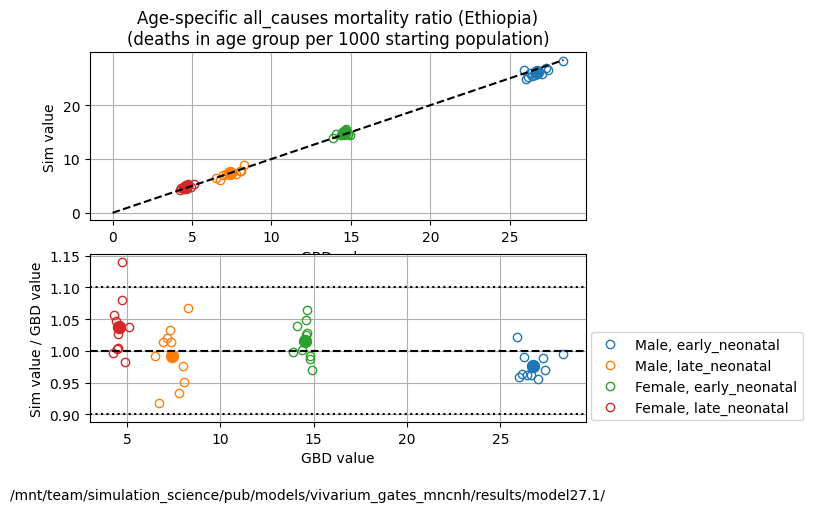

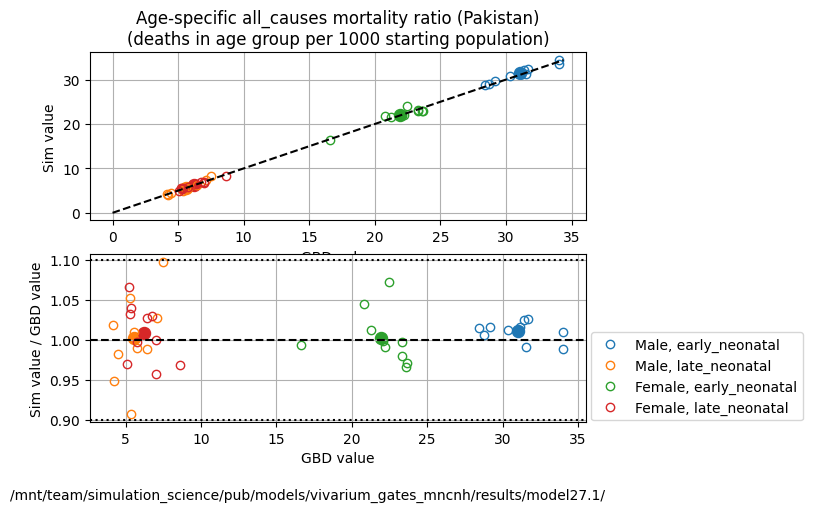

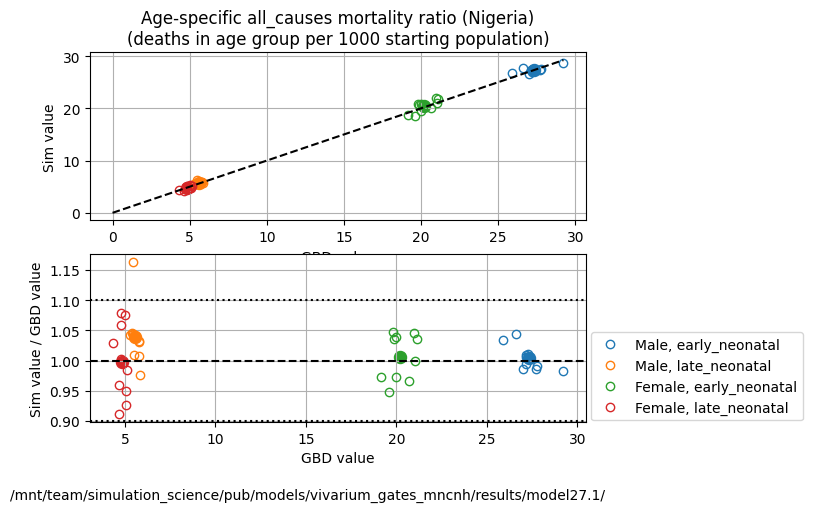

In [28]:
for location in locations:
    plot_mortality_risk('all_causes',location)

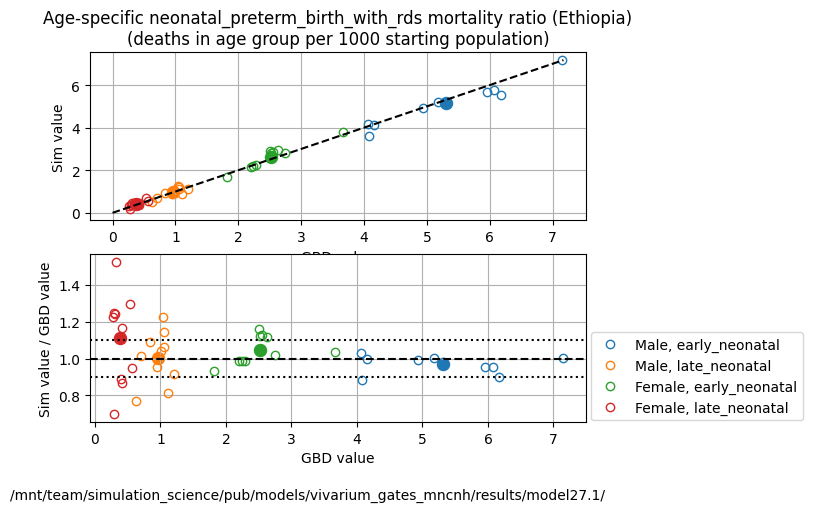

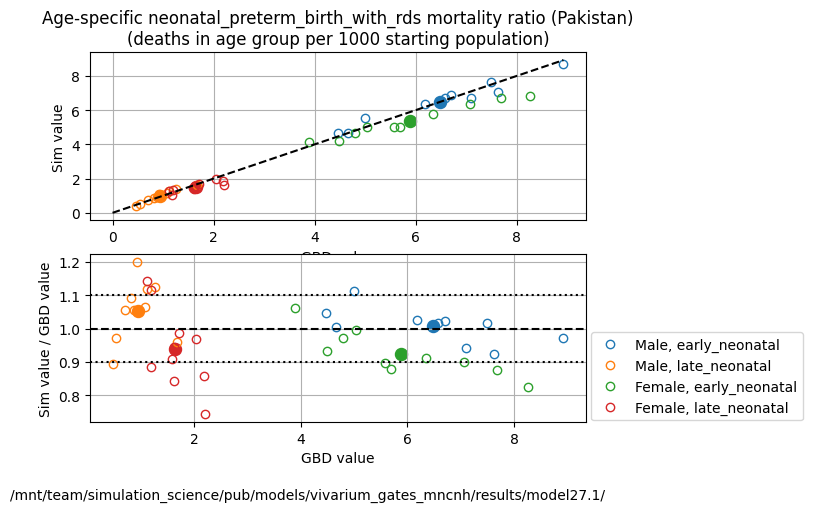

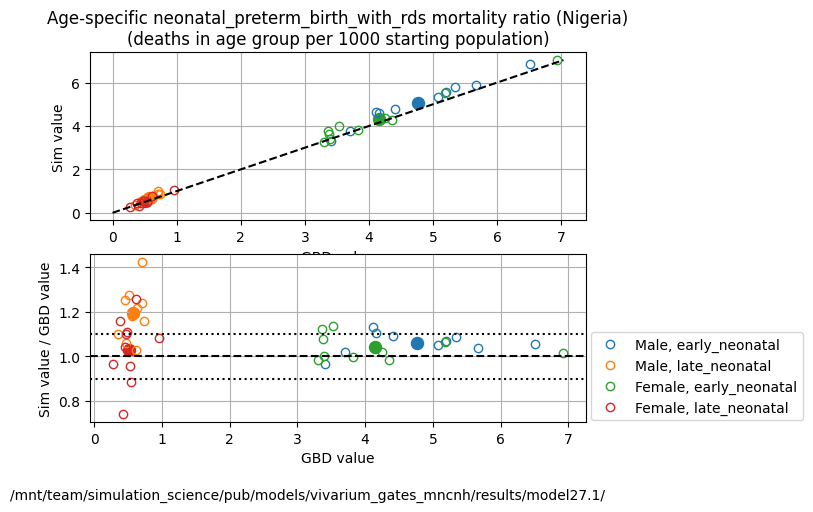

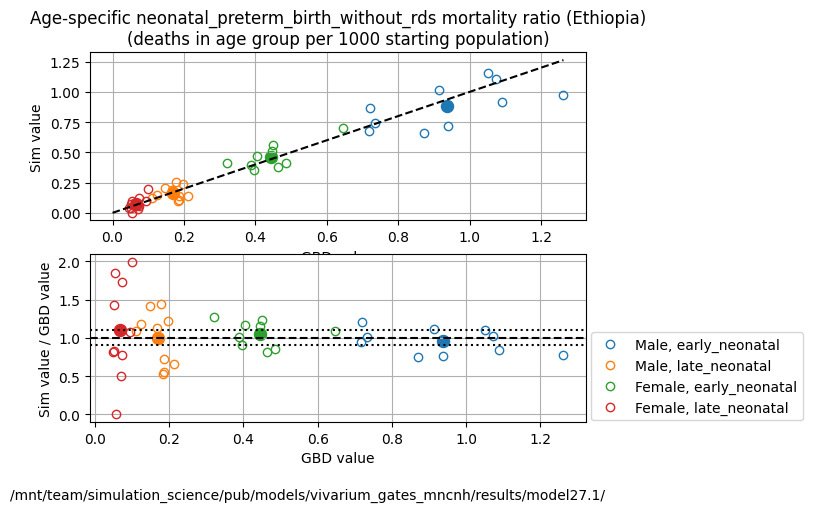

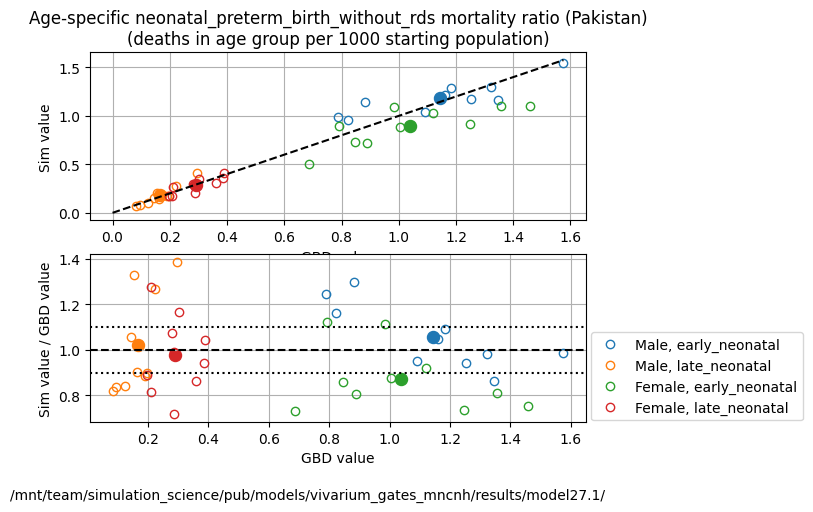

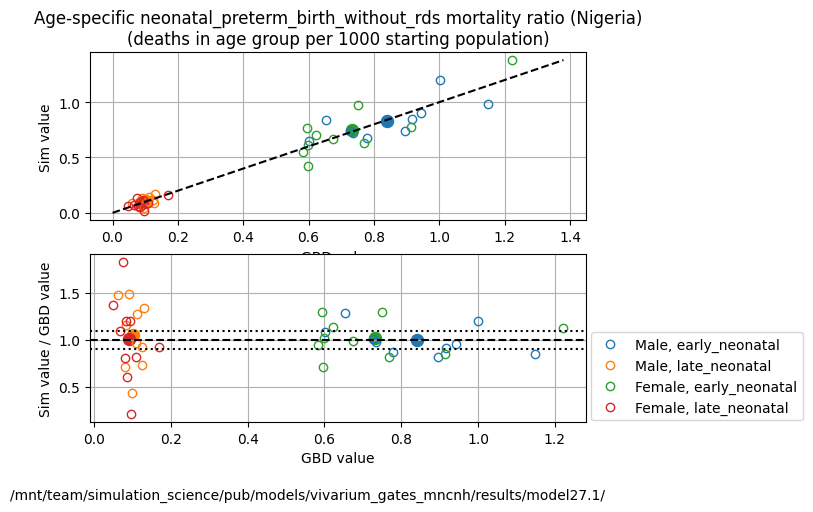

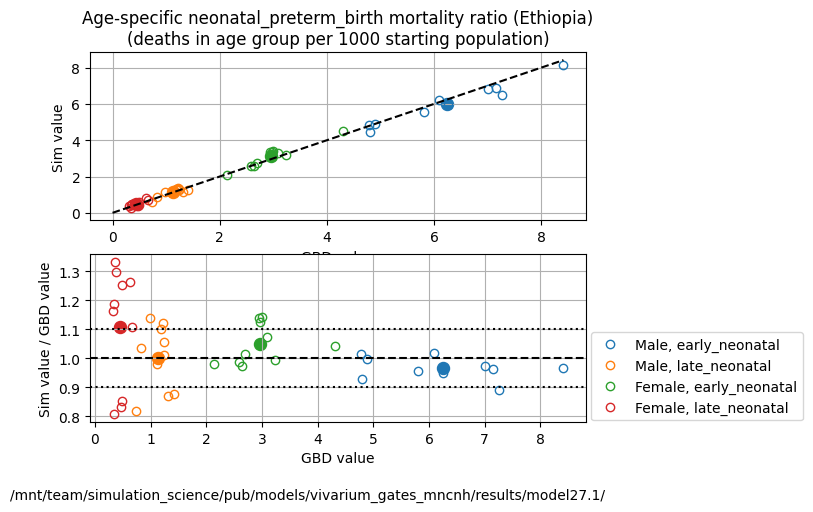

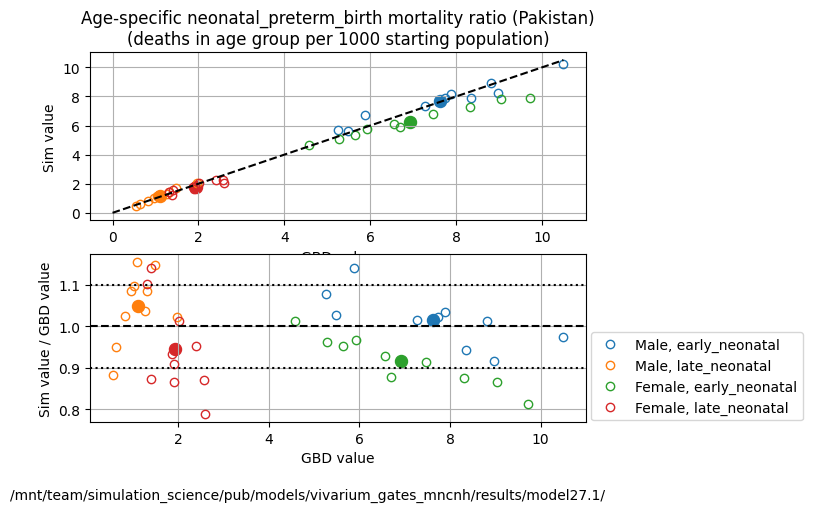

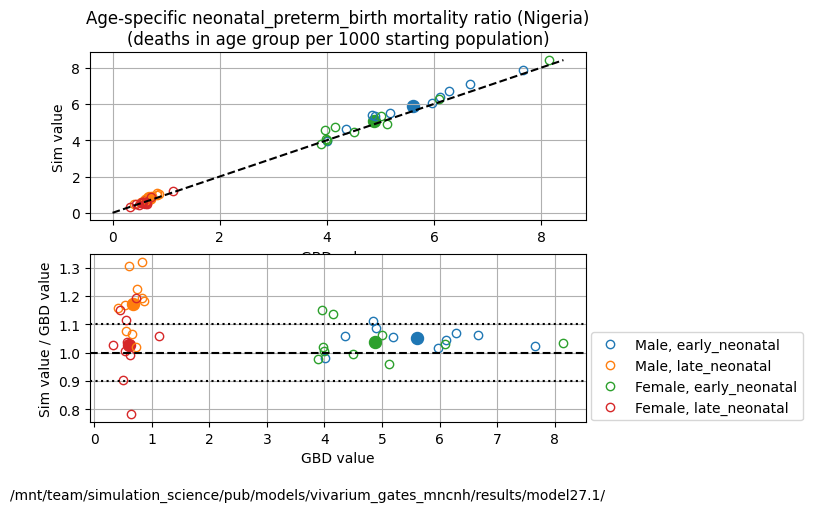

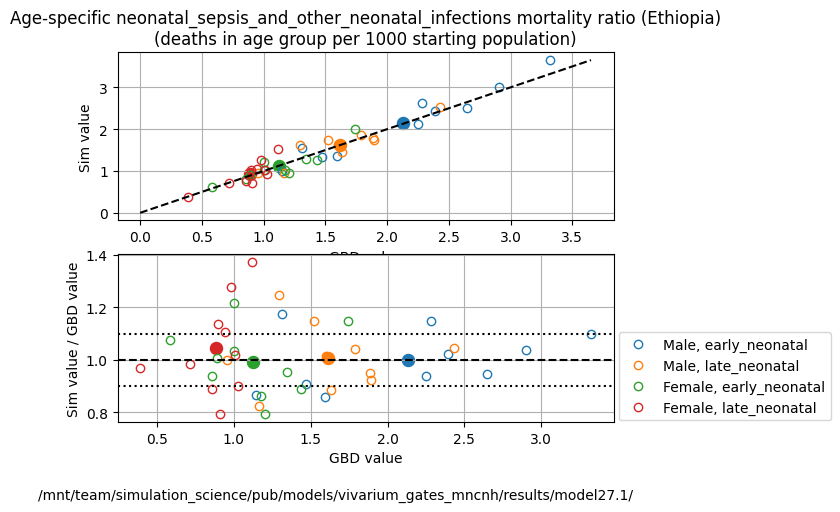

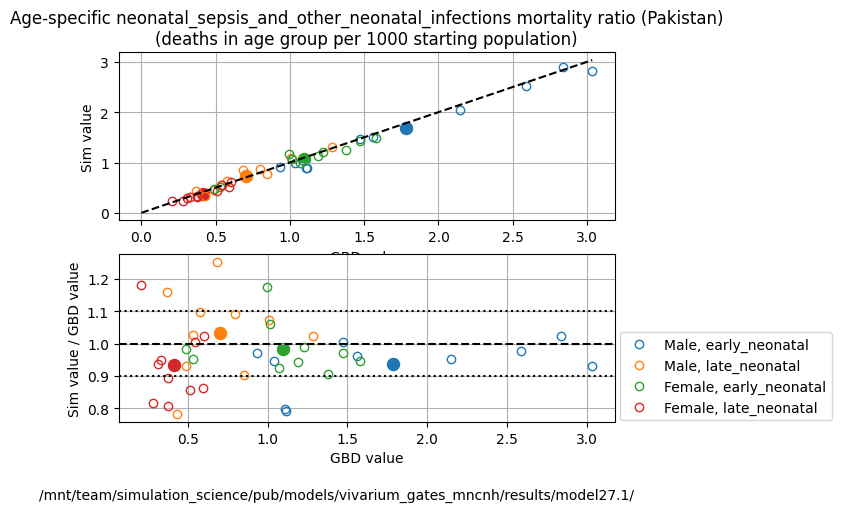

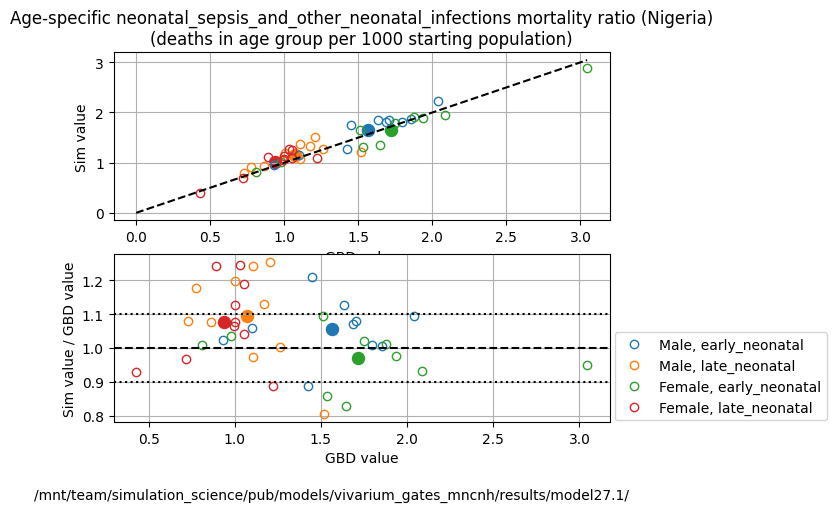

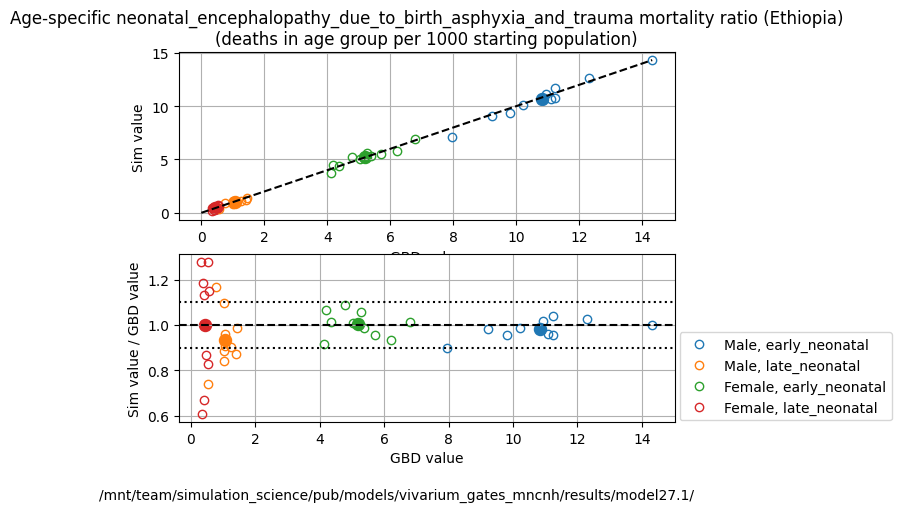

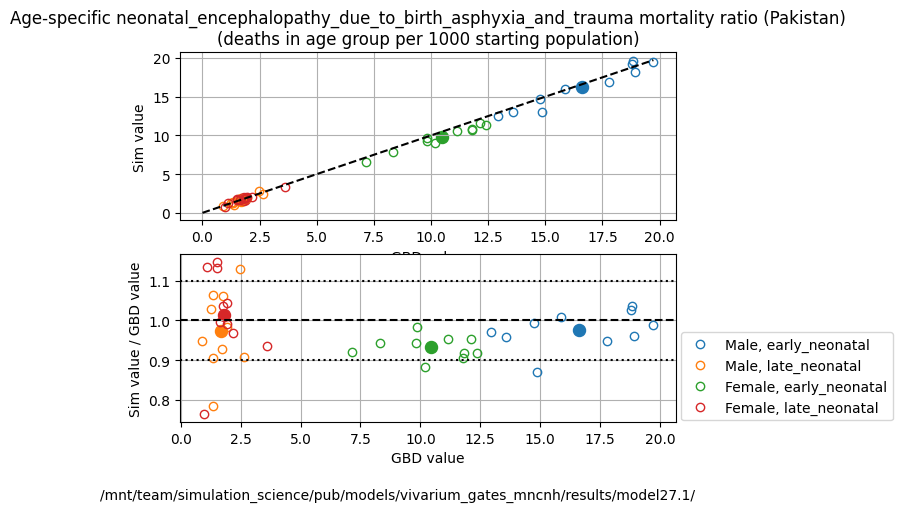

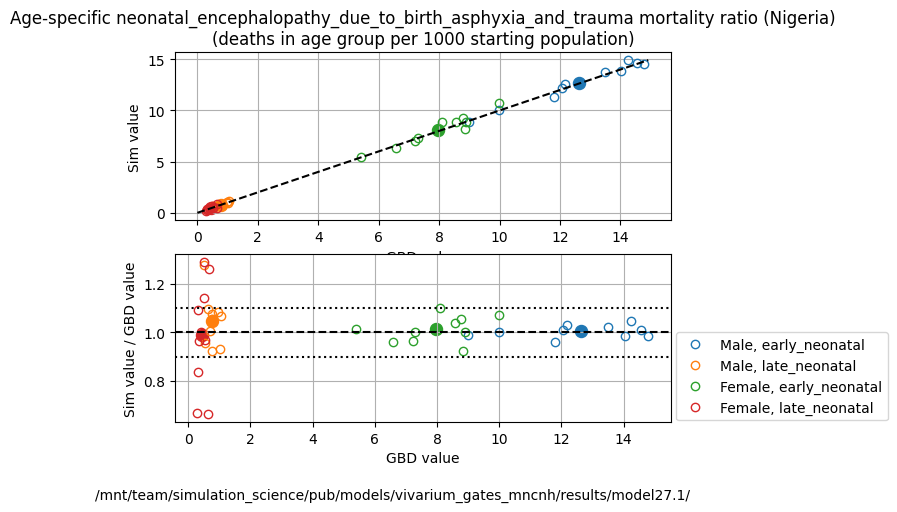

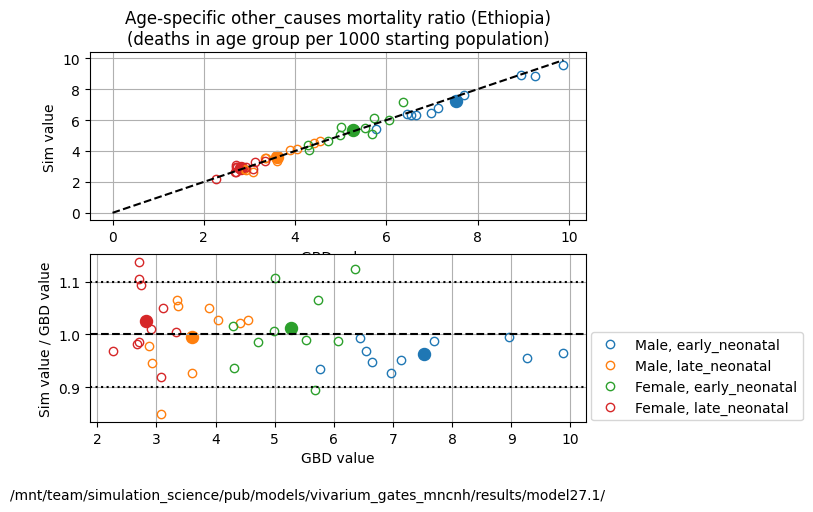

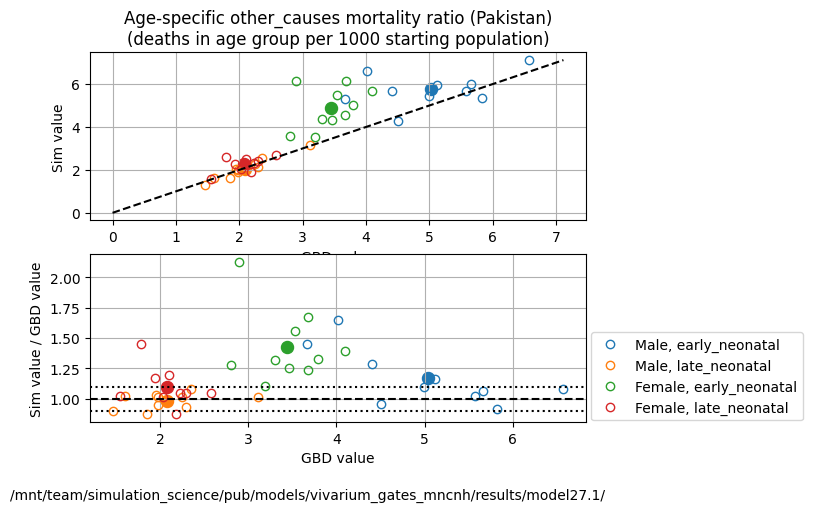

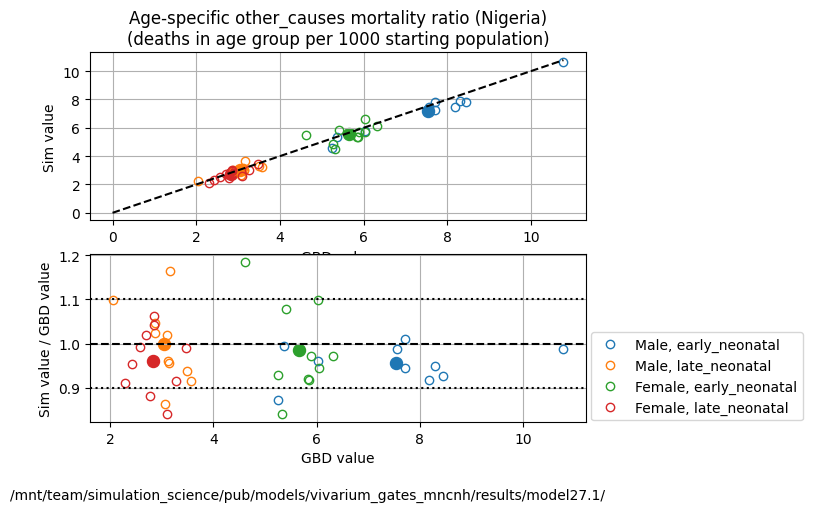

In [29]:
causes = [
       'neonatal_preterm_birth_with_rds',
       'neonatal_preterm_birth_without_rds',
       'neonatal_preterm_birth',
       'neonatal_sepsis_and_other_neonatal_infections',
       'neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma',
       'other_causes',
       ]

for cause in causes:
    for location in locations:
        plot_mortality_risk(cause, location)

# these all look reasonable, though I don't know what is happening with other_causes in Pakistan
# this has been the case since model 19.1.x, though
# TODO: plot information about the precision/sample size

In [30]:
# intervention checks

In [31]:
# TODO: I don't get this variable name, nor the observer name
pop = read_results('anc_other', baseline_only=False)
pop.head()

,acs_availability,acs_eligibility,age_group,anc_coverage,azithromycin_availability,believed_preterm,delivery_facility_type,misoprostol_availability,pregnancy_outcome,preterm_birth,ultrasound_type,scenario,input_draw,location,value
0,False,False,10_to_14,first_trimester_and_later_pregnancy,False,False,BEmONC,False,live_birth,False,AI_assisted,anemia_screening_and_iv_iron_scaleup,22,ethiopia,0.0
1,False,False,10_to_14,first_trimester_and_later_pregnancy,False,False,BEmONC,False,live_birth,False,AI_assisted,anemia_screening_and_iv_iron_scaleup,60,ethiopia,0.0
2,False,False,10_to_14,first_trimester_and_later_pregnancy,False,False,BEmONC,False,live_birth,False,AI_assisted,anemia_screening_and_iv_iron_scaleup,71,ethiopia,0.0
3,False,False,10_to_14,first_trimester_and_later_pregnancy,False,False,BEmONC,False,live_birth,False,AI_assisted,anemia_screening_and_iv_iron_scaleup,79,ethiopia,0.0
4,False,False,10_to_14,first_trimester_and_later_pregnancy,False,False,BEmONC,False,live_birth,False,AI_assisted,anemia_screening_and_iv_iron_scaleup,115,ethiopia,0.0


In [32]:
assert births.loc[(births.acs_availability) & (~births.acs_eligibility)]['value'].sum() == 0, 'ACS coverage among ACS ineligible population'
assert births.loc[(births.acs_availability) & (~births.cpap_availability)]['value'].sum() == 0, 'ACS coverage among population without CPAP coverage'
assert births.loc[(births.delivery_facility_type.isin(['home','none']))
                  &(births.acs_availability)]['value'].sum() == 0, 'ACS coverage among home births and/or partial term pregnancies'

In [33]:
cols = ['location','input_draw','scenario','delivery_facility_type']
acs_cov = (births.loc[births.acs_eligibility].groupby(cols + ['acs_availability'])['value'].sum()
       /births.loc[births.acs_eligibility].groupby(cols)['value'].sum())
acs_cov = acs_cov.groupby([x for x in cols if x != 'input_draw'] + ['acs_availability']).describe(percentiles=[0.025,0.975]).reset_index()
acs_cov = acs_cov.loc[(acs_cov.acs_availability) & (acs_cov.delivery_facility_type.isin(['BEmONC','CEmONC']))]
acs_cov

,location,scenario,delivery_facility_type,acs_availability,count,mean,std,min,2.5%,50%,97.5%,max
1,ethiopia,baseline,BEmONC,True,10.0,0.073729,0.007853,0.059976,0.060873,0.073493,0.083658,0.083924
3,ethiopia,baseline,CEmONC,True,10.0,0.381581,0.007373,0.368595,0.369616,0.381891,0.391622,0.391663
9,nigeria,baseline,BEmONC,True,10.0,0.071458,0.011759,0.057659,0.057862,0.071302,0.093168,0.096939
11,nigeria,baseline,CEmONC,True,10.0,0.383146,0.012959,0.364921,0.365966,0.380761,0.400398,0.401365
17,pakistan,baseline,BEmONC,True,10.0,0.070124,0.004033,0.063750,0.064334,0.069679,0.076286,0.076368
19,pakistan,baseline,CEmONC,True,10.0,0.374408,0.014462,0.349948,0.352117,0.373832,0.392611,0.393162


In [34]:
births.loc[births.acs_eligibility]['value'].sum().sum()

297093.0

In [35]:
cols = ['location','input_draw','scenario','delivery_facility_type']
cpap_cov = (births.groupby(cols + ['cpap_availability'])['value'].sum()
       /births.groupby(cols)['value'].sum())
cpap_cov = cpap_cov.groupby([x for x in cols if x != 'input_draw'] + ['cpap_availability']).describe(percentiles=[0.025,0.975]).reset_index()
cpap_cov = cpap_cov.loc[(cpap_cov.cpap_availability) & (cpap_cov.delivery_facility_type.isin(['BEmONC','CEmONC']))]
cpap_cov

# This is looking a bit low?
# coverage docs are here: https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/neonatal/cpap_intervention.html#id6
# BEmONC should be 7.5%, CEmONC 39.3%
# TODO: Plot coverage for both ACS and CPAP

,location,scenario,delivery_facility_type,cpap_availability,count,mean,std,min,2.5%,50%,97.5%,max
1,ethiopia,baseline,BEmONC,True,10.0,0.072662,0.001658,0.069040,0.069681,0.072967,0.075098,0.075448
3,ethiopia,baseline,CEmONC,True,10.0,0.381471,0.003152,0.377101,0.377284,0.381837,0.386471,0.387142
9,nigeria,baseline,BEmONC,True,10.0,0.071965,0.001942,0.069721,0.069802,0.071590,0.075555,0.076076
11,nigeria,baseline,CEmONC,True,10.0,0.379708,0.003249,0.375296,0.375536,0.378912,0.384706,0.384853
17,pakistan,baseline,BEmONC,True,10.0,0.071483,0.001066,0.070137,0.070230,0.071454,0.073537,0.073880
19,pakistan,baseline,CEmONC,True,10.0,0.376405,0.005576,0.367095,0.368064,0.376199,0.383938,0.384383


In [36]:
deaths_by_intervention_status = (
    deaths
        .groupby(['input_draw','scenario','neonatal_burden_observer_cause_of_death','acs_eligibility','cpap_availability', 'preterm_birth'])
        ['value'].sum()
)
starting_population_by_intervention_status = (
    births.loc[births.pregnancy_outcome=='live_birth']
        .groupby(['input_draw','scenario','acs_eligibility','cpap_availability', 'preterm_birth'])
        ['value'].sum()
)
mortality_risk = (deaths_by_intervention_status / starting_population_by_intervention_status)
mortality_risk

input_draw  scenario  acs_eligibility  cpap_availability  preterm_birth  neonatal_burden_observer_cause_of_death                 
22          baseline  False            False              False          all_causes                                                  0.016552
                                                                         neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma    0.005713
                                                                         neonatal_preterm_birth                                      0.000000
                                                                         neonatal_preterm_birth_with_rds                             0.000000
                                                                         neonatal_preterm_birth_without_rds                          0.000000
                                                                                                                                       ...   
244         baseli

In [37]:
mort_acs = (deaths.loc[(deaths.acs_availability) & (deaths.acs_eligibility)
    &(deaths.delivery_facility_type=='CEmONC')].groupby(['input_draw','neonatal_burden_observer_cause_of_death'])['value'].sum()
            / births.loc[(births.acs_availability) & (births.acs_eligibility)    
    &(births.delivery_facility_type=='CEmONC')].groupby('input_draw')['value'].sum())
mort_no_acs = (deaths.loc[(~deaths.acs_availability) & (deaths.acs_eligibility)
    &(deaths.delivery_facility_type=='CEmONC')].groupby(['input_draw','neonatal_burden_observer_cause_of_death'])['value'].sum()
            / births.loc[(~births.acs_availability) & (births.acs_eligibility)
    &(births.delivery_facility_type=='CEmONC')].groupby('input_draw')['value'].sum())
rr_acs = mort_acs / mort_no_acs
rr_acs.groupby('neonatal_burden_observer_cause_of_death').describe()

# RR = 0.84 (95% CI 0.72-0.97) this is the ACS RR... but by definition everyone with ACS also has CPAP
# so the target is actually that multiplied by CPAP effect of 0.53 (95% CI 0.34-0.83).

# for a summary measure of 0.44, which we are fairly close to

# not sure why we are seeing RR values > 1 for preterm without RDS, sepsis, and other causes
# could it be something to do with a fractional decrease in the competing causes of deaths
# like we don't actually avert a death due to RDS, but we rather change the cause of death from RDS to another cause?

# that's my best guess here, but maybe we should look into it a bit more

,count,mean,std,min,25%,50%,75%,max
neonatal_burden_observer_cause_of_death,,,,,,,,
all_causes,10.0,0.850316,0.047520,0.795039,0.819800,0.840026,0.870061,0.928629
neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,10.0,1.054500,0.115918,0.887735,0.958921,1.054775,1.159406,1.207726
neonatal_preterm_birth,10.0,0.557338,0.114718,0.399865,0.469507,0.542595,0.664760,0.719889
neonatal_preterm_birth_with_rds,10.0,0.477381,0.114579,0.322800,0.414789,0.474432,0.510980,0.700403
neonatal_preterm_birth_without_rds,10.0,1.072693,0.374421,0.639477,0.870965,0.944129,1.320096,1.836876
neonatal_sepsis_and_other_neonatal_infections,10.0,0.969917,0.276370,0.490355,0.779016,0.930337,1.192464,1.383784
other_causes,10.0,1.110134,0.285169,0.817501,0.911345,1.012124,1.251983,1.585537


In [38]:
mort_cpap = (deaths.loc[(deaths.cpap_availability) & (~deaths.acs_eligibility) 
            & (deaths.preterm_birth) & (deaths.delivery_facility_type=='CEmONC')].groupby(['input_draw','neonatal_burden_observer_cause_of_death'])['value'].sum()
            / births.loc[(births.cpap_availability) & (~births.acs_eligibility)
                & (births.preterm_birth)&(births.delivery_facility_type=='CEmONC')].groupby('input_draw')['value'].sum())
mort_no_cpap = (deaths.loc[(~deaths.cpap_availability) & (~deaths.acs_eligibility) 
    & (deaths.preterm_birth)&(deaths.delivery_facility_type=='CEmONC')].groupby(['input_draw','neonatal_burden_observer_cause_of_death'])['value'].sum()
            / births.loc[(~births.cpap_availability) & (~births.acs_eligibility) 
                & (births.preterm_birth)&(births.delivery_facility_type=='CEmONC')].groupby('input_draw')['value'].sum())
rr_cpap = mort_cpap / mort_no_cpap
rr_cpap.groupby('neonatal_burden_observer_cause_of_death').describe()

# target CPAP effect of 0.53 (95% CI 0.34-0.83).
# looks good!
# but we do still see some elevated risk due to other causes...
# I think maybe due to the same issue discussed in the notes above

,count,mean,std,min,25%,50%,75%,max
neonatal_burden_observer_cause_of_death,,,,,,,,
all_causes,10.0,0.867750,0.079031,0.745816,0.826111,0.862378,0.885977,1.030103
neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,10.0,0.998672,0.103939,0.839984,0.924400,0.988097,1.076078,1.169307
neonatal_preterm_birth,10.0,0.644487,0.155356,0.479148,0.542504,0.618898,0.695604,1.011479
neonatal_preterm_birth_with_rds,10.0,0.574954,0.155480,0.375655,0.459605,0.567486,0.635483,0.923793
neonatal_preterm_birth_without_rds,10.0,1.148165,0.385949,0.608534,0.825522,1.237379,1.374913,1.786810
neonatal_sepsis_and_other_neonatal_infections,10.0,1.049903,0.318751,0.631644,0.747255,1.108401,1.217151,1.511438
other_causes,10.0,1.094953,0.232418,0.742723,1.018939,1.072563,1.201020,1.496603
